In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
data_root = '/gdrive/My Drive/data_worthcheck/' #pastikan folder data_worthcheck sudah diupload di Google Drive Anda

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import pandas as pd

ps = pd.read_csv(data_root + 'dev.csv')
dtext_a = list(ps['text_a'])
ps = pd.read_csv(data_root +'train.csv')
ttext_a = list(ps['text_a'])
tlabel = list(ps['label'])

text_a = []
label = []
count = 0
for t,l in zip(ttext_a, tlabel):
    if t in dtext_a:
        count += 1
    else:
        text_a.append(t)
        label.append(l)
if count:
    print(len(ttext_a), count, len(text_a))
    dic = {'text_a':text_a, 'label':label}
    ps = pd.DataFrame(dic)
    ps.to_csv('train_filtered.csv')

In [ ]:
ps.drop(columns=ps.columns[0], axis=1, inplace=True)
df = ps
df

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no
...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,no
21597,oxfara arie kriting yg lebi goblo nya orang ke...,no
21598,virus corona menyaba depok cuci tangan makan n...,no
21599,mata sipit tinggal depok udah abis dah bahan c...,no


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,0
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,0
2,e100ss gini buka informasi sejelas nya identit...,1
3,neng solo wes ono terduga corona cobo neng ati...,0
4,midiahn nii akun gak takut takut nya isu coron...,0
...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,0
21597,oxfara arie kriting yg lebi goblo nya orang ke...,0
21598,virus corona menyaba depok cuci tangan makan n...,0
21599,mata sipit tinggal depok udah abis dah bahan c...,0


In [ ]:
val = pd.read_csv(data_root + 'dev.csv')
val['label'] = le.fit_transform(val['label'])
val

,text_a,label
0,jek dajal ga depok bang,0
1,detikcom untung depok masuk wilayah nya ridwan...,0
2,df dom jakarta depok yg gunain vc cabang nya c...,0
3,your2rl depok jkt,0
4,doakan indonesia selamat virus corona pkb depo...,1
...,...,...
2795,ku tenang2 bae ku sih ya corona nya ga depok k...,0
2796,guru hati hati ya virus corona uda indonesia t...,1
2797,4 terawan menyebut virus corona indonesia terd...,1
2798,realffk buhari can t pronounce corona virus,0


In [ ]:
tst = pd.read_csv(data_root + 'test.csv')
tst['label'] = le.fit_transform(tst['label'])
tst

,text_a,label
0,jek dajal ga depok bang,0
1,detikcom untung depok masuk wilayah nya ridwan...,0
2,df dom jakarta depok yg gunain vc cabang nya c...,0
3,your2rl depok jkt,0
4,doakan indonesia selamat virus corona pkb depo...,1
...,...,...
2795,ku tenang2 bae ku sih ya corona nya ga depok k...,0
2796,guru hati hati ya virus corona uda indonesia t...,1
2797,4 terawan menyebut virus corona indonesia terd...,1
2798,realffk buhari can t pronounce corona virus,0


In [ ]:
# split train dataset into train, validation and test sets
train_text = df['text_a']
train_labels = df['label']
val_text = val['text_a']
test_text = tst['text_a']
val_labels = val['label']
test_labels = tst['label']

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


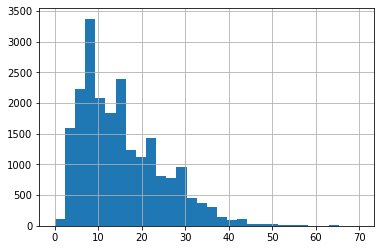

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30,range=[0, 70])

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-3)          # learning rate

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.69626741 1.77377238]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
import time, datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    t0 = time.time()
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    676.
  Batch   100  of    676.
  Batch   150  of    676.
  Batch   200  of    676.
  Batch   250  of    676.
  Batch   300  of    676.
  Batch   350  of    676.
  Batch   400  of    676.
  Batch   450  of    676.
  Batch   500  of    676.
  Batch   550  of    676.
  Batch   600  of    676.
  Batch   650  of    676.

Evaluating...
  Batch    50  of     88.

Training Loss: 0.658
Validation Loss: 0.592

 Epoch 2 / 10
  Batch    50  of    676.
  Batch   100  of    676.
  Batch   150  of    676.
  Batch   200  of    676.
  Batch   250  of    676.
  Batch   300  of    676.
  Batch   350  of    676.
  Batch   400  of    676.
  Batch   450  of    676.
  Batch   500  of    676.
  Batch   550  of    676.
  Batch   600  of    676.
  Batch   650  of    676.

Evaluating...
  Batch    50  of     88.

Training Loss: 0.619
Validation Loss: 0.629

 Epoch 3 / 10
  Batch    50  of    676.
  Batch   100  of    676.
  Batch   150  of    676.
  Batch   200  of    676.
  B

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      2093
           1       0.47      0.72      0.57       707

    accuracy                           0.72      2800
   macro avg       0.68      0.72      0.68      2800
weighted avg       0.78      0.72      0.74      2800

